In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Load Result Files of all Models

In [2]:
results_dict = {}

folder_path = "../bike_forecasting_hourly/results"

if os.path.exists(folder_path) and os.path.isdir(folder_path):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            file_path = os.path.join(folder_path, file_name)
            try:
                df = pd.read_csv(file_path, parse_dates=["Datetime"], index_col="Datetime")
                df.index = pd.to_datetime(df.index, utc=True)
                df.index = df.index.tz_convert('Europe/Berlin')
                
                results_dict[file_name[:-4]] = df
            except Exception as e:
                print(f"Error {file_name}: {e}")
else:
    print("Empty")

for key, value in results_dict.items():
    print(f"{key}: {value.shape}")

Baseline Forecast: (364, 6)
LightGBM: (364, 6)
Mean Ensemble: (364, 6)
Median Ensemble: (364, 6)
Quantile Regression Forest: (364, 6)
Quantile Regression: (364, 6)
XGBoost: (364, 6)


#### Filter Horizons

In [3]:
# Target-Horizons
target_horizons = [
    {"dayofweek": 1, "horizon": "1 day"},  # Freitag 12:00 Stunde: 36 
    {"dayofweek": 2, "horizon": "2 day"},  # Freitag 16:00 Stunde: 40
    {"dayofweek": 3, "horizon": "3 day"},  # Freitag 20:00 Stunde: 44
    {"dayofweek": 4, "horizon": "4 day"},  # Samstag 12:00 Stunde: 60
    {"dayofweek": 5, "horizon": "5 day"},  # Samstag 16:00 Stunde: 64
    {"dayofweek": 6, "horizon": "6 day"},  # Samstag 20:00 Stunde: 68
]

# Filter for target horizons
for key, df in results_dict.items():
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    df["dayofweek"] = df.index.dayofweek
    filtered_df = pd.DataFrame()

    for mapping in target_horizons:
        day = mapping["dayofweek"]
        horizon = mapping["horizon"]

        subset = df[(df["dayofweek"] == day)].copy()
        subset["horizon"] = horizon

        filtered_df = pd.concat([filtered_df, subset])
        filtered_df = filtered_df.drop(columns=["dayofweek"])

    results_dict[key] = filtered_df
    
for key, value in results_dict.items():
    print(f"{key}: {value.shape}")

Baseline Forecast: (312, 7)
LightGBM: (312, 7)
Mean Ensemble: (312, 7)
Median Ensemble: (312, 7)
Quantile Regression Forest: (312, 7)
Quantile Regression: (312, 7)
XGBoost: (312, 7)


#### Quantile Loss Overview

In [4]:
# Quantile Loss
quantile_loss_dict = {}
for key, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values

    loss_df = df.copy()

    for q_col in quantiles:
        q = float(q_col[1:])
        y_pred = df[q_col].values
        loss = np.where(y_pred > target, 
                         (1 - q) * (y_pred - target), 
                          q * (target - y_pred))
        loss_df[q_col] = loss

    quantile_loss_dict[key] = loss_df

In [5]:
summary_rows = []

for model_name, loss_df in quantile_loss_dict.items():
    quantile_cols = [col for col in loss_df.columns if col.startswith("q")]
    
    avg_losses = loss_df[quantile_cols].mean()

    total_loss = avg_losses.sum()
    
    row = avg_losses.to_dict()
    row['Total Average Loss'] = total_loss
    row['Model'] = model_name
    
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index('Model')
summary_df = summary_df[sorted([col for col in summary_df.columns if col.startswith("q")]) + ['Total Average Loss']]

summary_df = summary_df.sort_values(by='Total Average Loss', ascending=False)

summary_df = summary_df.round(2)

In [6]:
summary_df

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
Model,,,,,,
Baseline Forecast,165.23,354.93,371.90,254.74,60.24,1207.04
Quantile Regression,55.00,237.18,281.52,239.39,53.72,866.80
Quantile Regression Forest,41.77,160.80,187.55,173.15,52.13,615.40
XGBoost,42.95,142.00,173.20,146.97,46.50,551.63
Mean Ensemble,40.88,143.77,168.88,149.23,42.28,545.05
Median Ensemble,40.88,143.77,168.88,149.23,42.28,545.05
LightGBM,39.28,145.87,166.41,152.08,38.06,541.71


#### Qauntil Coverage Overview

In [7]:
# Covergae by

coverage_dict = {}

for model_name, df in results_dict.items():
    quantiles = [col for col in df.columns if col.startswith("q")]
    target = df["target"].values
    coverage_df = pd.DataFrame(index=df.index)

    for q_col in quantiles:
        preds = df[q_col].values
        coverage_df[q_col] = (target <= preds).astype(int)

    coverage_dict[model_name] = coverage_df

In [8]:
coverage_rows = []

for model_name, coverage_df in coverage_dict.items():
    avg_coverage = coverage_df.mean()
    row = avg_coverage.to_dict()
    row["Modell"] = model_name
    coverage_rows.append(row)

coverage_summary = pd.DataFrame(coverage_rows)
coverage_summary = coverage_summary.set_index("Modell")
coverage_summary = coverage_summary[sorted(coverage_summary.columns)]


In [9]:
coverage_summary.round(2)

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
Baseline Forecast,0.18,0.31,0.48,0.70,0.87
LightGBM,0.01,0.19,0.54,0.88,1.00
Mean Ensemble,0.01,0.20,0.55,0.88,1.00
Median Ensemble,0.01,0.20,0.55,0.88,1.00
Quantile Regression Forest,0.00,0.13,0.53,0.90,1.00
Quantile Regression,0.01,0.13,0.50,0.81,1.00
XGBoost,0.01,0.21,0.56,0.87,1.00


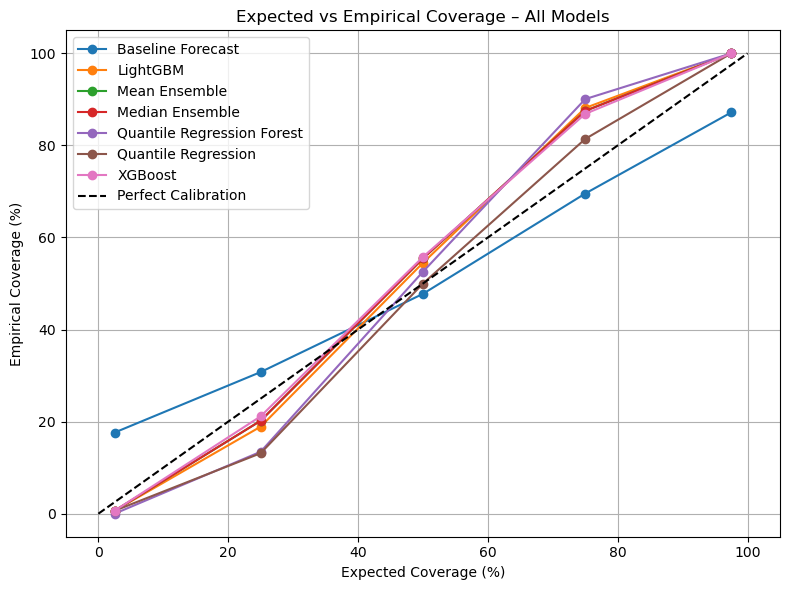

In [10]:
plt.figure(figsize=(8, 6))

expected_coverages = [float(col[1:]) * 100 for col in coverage_summary.columns]

for model_name, row in coverage_summary.iterrows():
    plt.plot(expected_coverages, row.values * 100, marker='o', label=model_name)

plt.plot([0, 100], [0, 100], linestyle='--', color='black', label="Perfect Calibration")

plt.xlabel("Expected Coverage (%)")
plt.ylabel("Empirical Coverage (%)")
plt.title("Expected vs Empirical Coverage – All Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
expected_coverage = {col: float(col[1:]) for col in coverage_summary.columns}

calibration_deviation = pd.DataFrame(index=coverage_summary.index)

for col in coverage_summary.columns:
    calibration_deviation[col] = expected_coverage[col] - coverage_summary[col]

calibration_deviation = calibration_deviation.round(2)


In [12]:
calibration_deviation

,q0.025,q0.25,q0.5,q0.75,q0.975
Modell,,,,,
Baseline Forecast,-0.15,-0.06,0.02,0.05,0.10
LightGBM,0.02,0.06,-0.04,-0.13,-0.03
Mean Ensemble,0.02,0.05,-0.05,-0.12,-0.03
Median Ensemble,0.02,0.05,-0.05,-0.12,-0.03
Quantile Regression Forest,0.02,0.12,-0.03,-0.15,-0.03
Quantile Regression,0.02,0.12,0.00,-0.06,-0.03
XGBoost,0.02,0.04,-0.06,-0.12,-0.03


#### Interval Coverage

In [13]:
interval_coverage_rows = []

for model_name, df in results_dict.items():
    lower_95 = df["q0.025"]
    upper_95 = df["q0.975"]
    lower_50 = df["q0.25"]
    upper_50 = df["q0.75"]
    target = df["target"]

    coverage_95 = ((target >= lower_95) & (target <= upper_95)).mean()
    coverage_50 = ((target >= lower_50) & (target <= upper_50)).mean()

    interval_coverage_rows.append({
        "Modell": model_name,
        "CI_50 Coverage": coverage_50,
        "CI_95 Coverage": coverage_95
    })

interval_coverage_df = pd.DataFrame(interval_coverage_rows)
interval_coverage_df = interval_coverage_df.set_index("Modell").round(2)


#### Quantile Loss and Coverage

In [14]:
quantile_loss_ci_coverage = summary_df.copy()
quantile_loss_ci_coverage = quantile_loss_ci_coverage.join(interval_coverage_df)

In [15]:
quantile_loss_ci_coverage

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage
Model,,,,,,,,
Baseline Forecast,165.23,354.93,371.90,254.74,60.24,1207.04,0.39,0.70
Quantile Regression,55.00,237.18,281.52,239.39,53.72,866.80,0.69,0.99
Quantile Regression Forest,41.77,160.80,187.55,173.15,52.13,615.40,0.77,1.00
XGBoost,42.95,142.00,173.20,146.97,46.50,551.63,0.66,0.99
Mean Ensemble,40.88,143.77,168.88,149.23,42.28,545.05,0.67,0.99
Median Ensemble,40.88,143.77,168.88,149.23,42.28,545.05,0.67,0.99
LightGBM,39.28,145.87,166.41,152.08,38.06,541.71,0.69,0.99


##### Model Results Visualization

C:\Users\Tim Flaschel\AppData\Local\Temp\ipykernel_6524\996301231.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc["2024-11-01":]


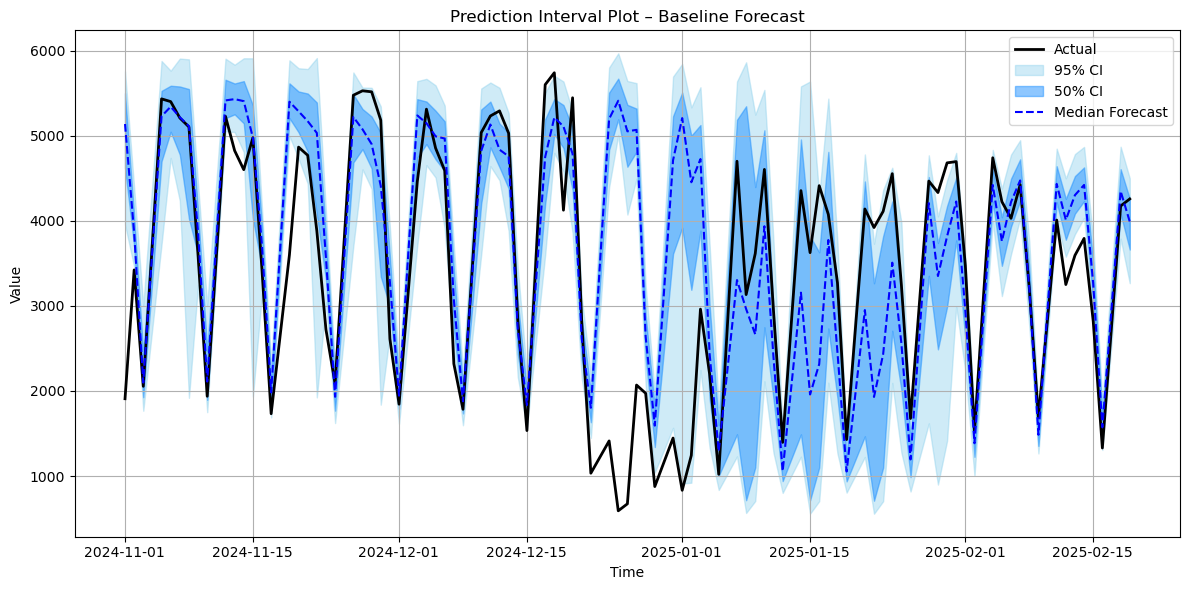

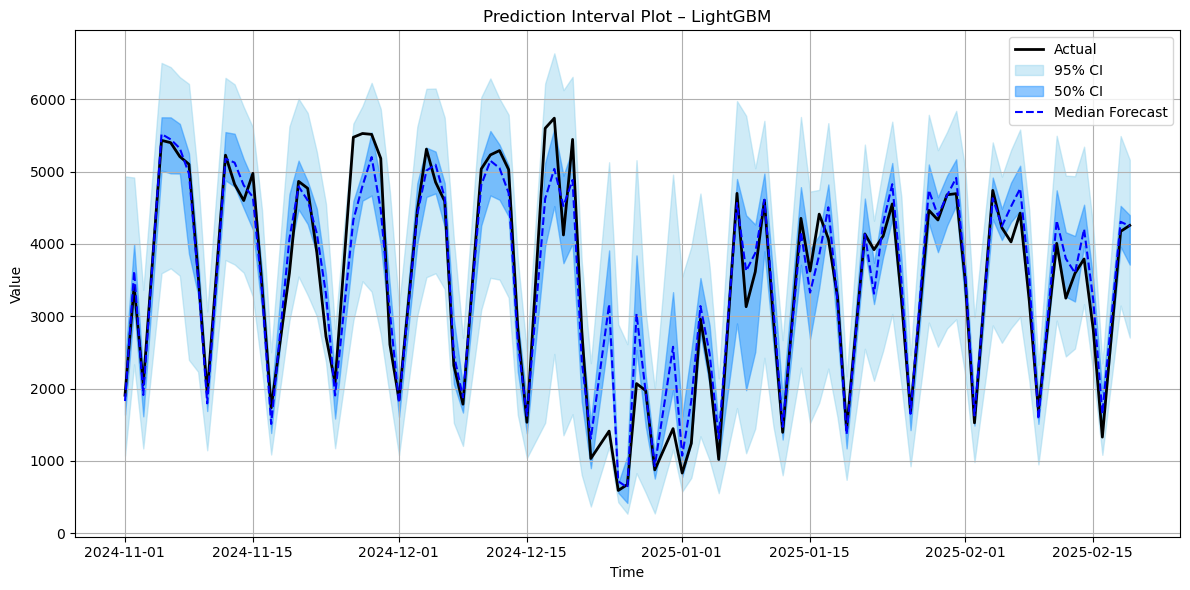

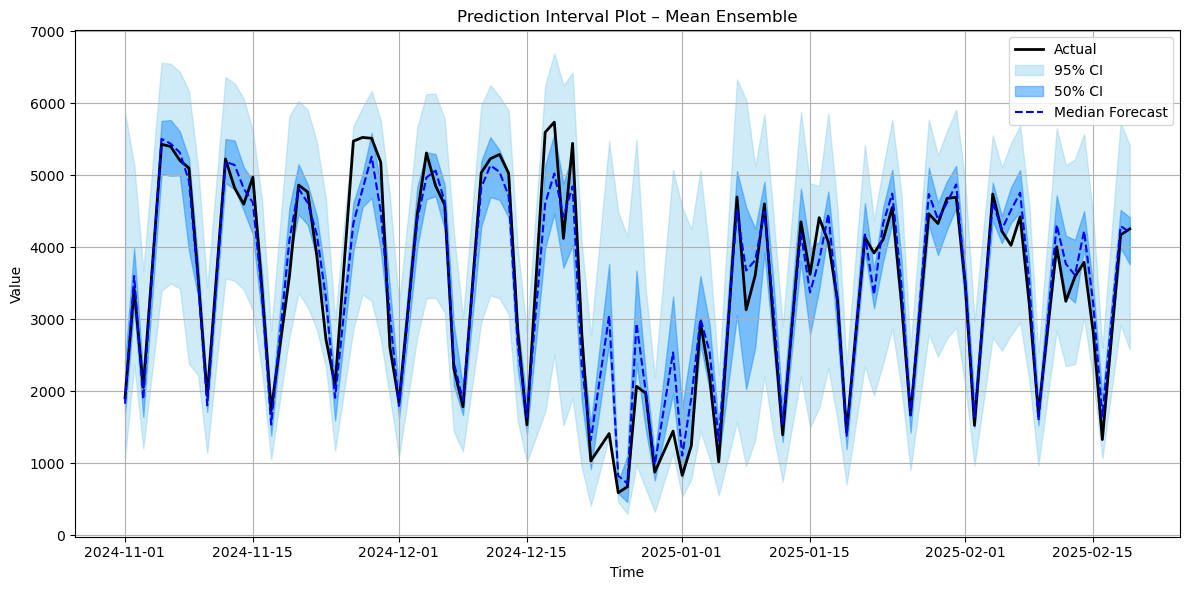

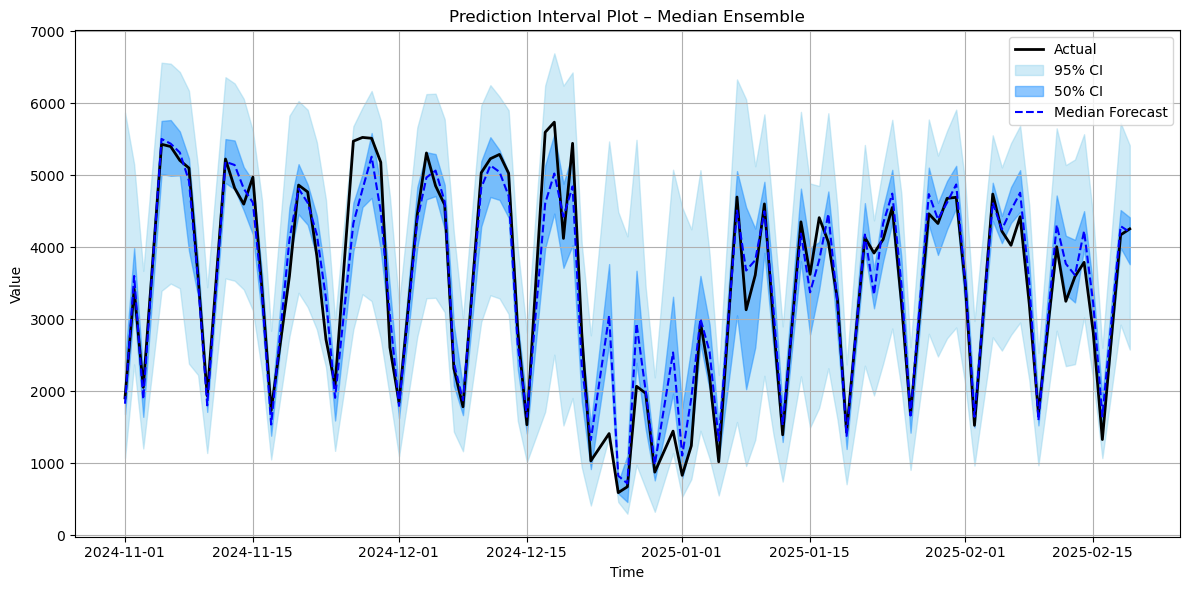

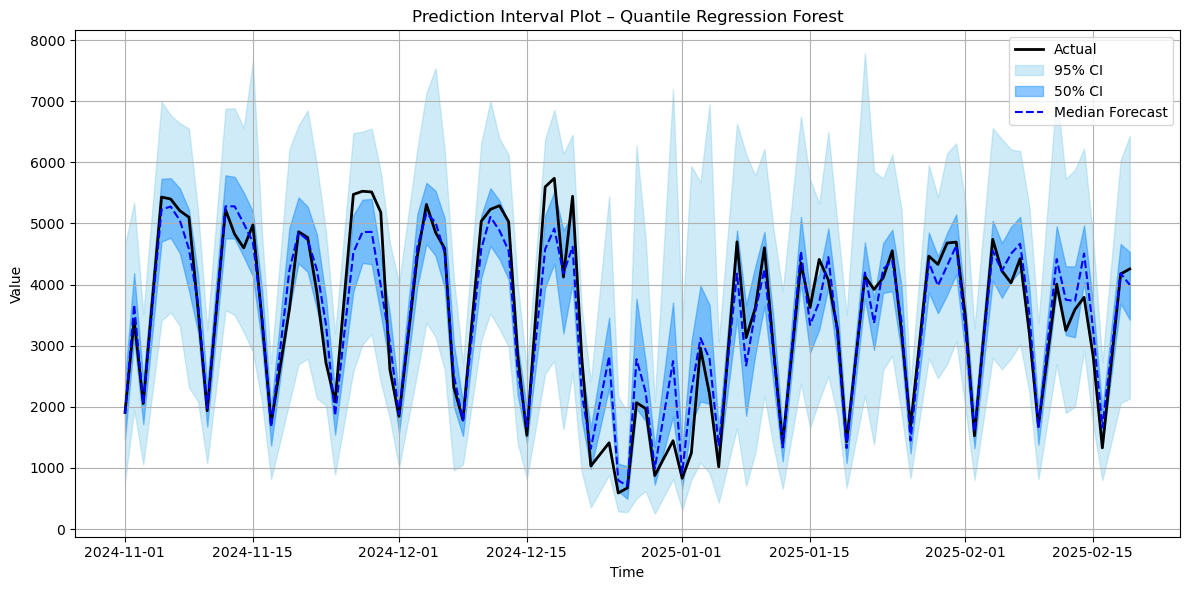

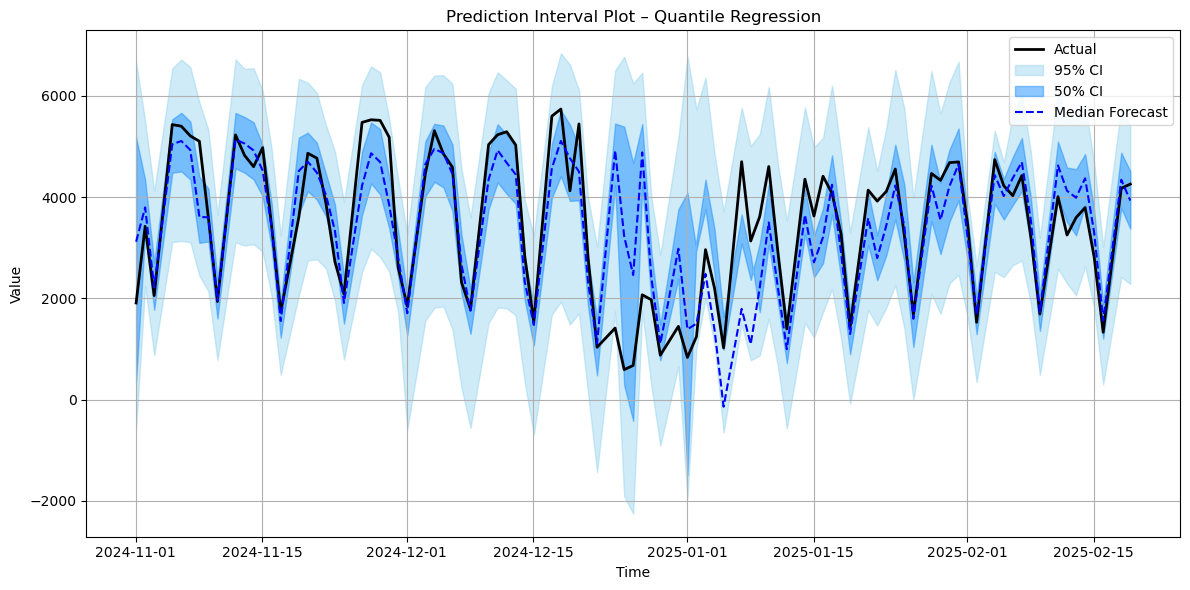

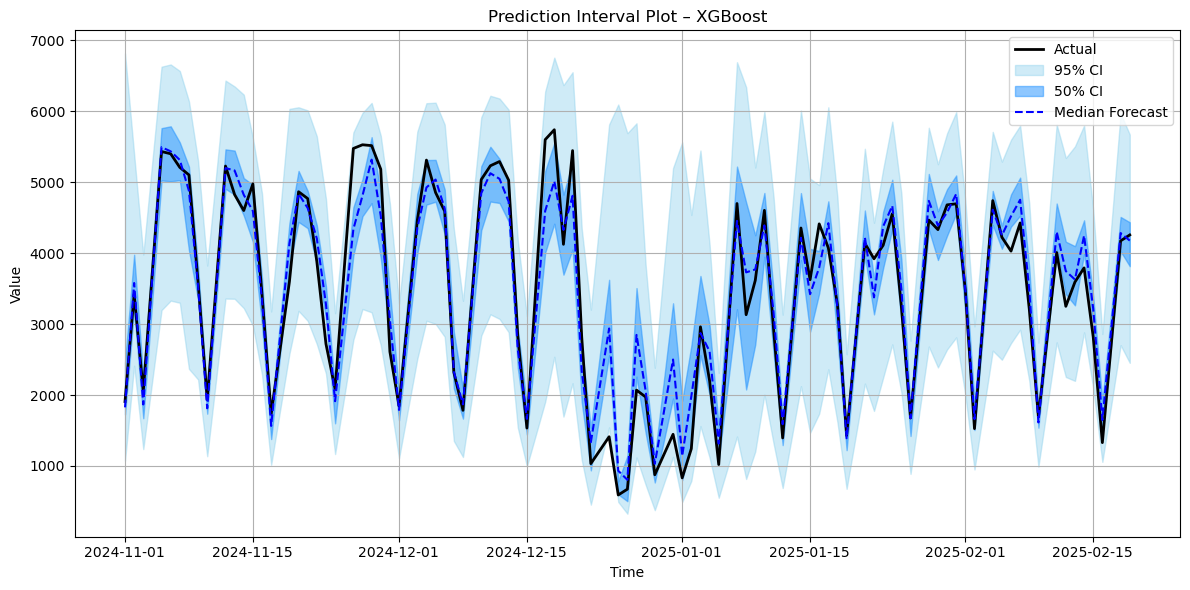

In [16]:
for model_name, df in results_dict.items():
    # Filter by date range
    
    df = df.loc["2024-11-01":]
    plt.figure(figsize=(12, 6))
    df = df.sort_index()
    x = df.index
    y_actual = df["target"]
    q025 = df["q0.025"]
    q975 = df["q0.975"]
    q25 = df["q0.25"]
    q75 = df["q0.75"]
    q50 = df["q0.5"]

    plt.plot(x, y_actual, color="black", label="Actual", linewidth=2)
    plt.fill_between(x, q025, q975, color="skyblue", alpha=0.4, label="95% CI")
    plt.fill_between(x, q25, q75, color="dodgerblue", alpha=0.5, label="50% CI")
    plt.plot(x, q50, color="blue", linestyle="--", label="Median Forecast")

    plt.title(f"Prediction Interval Plot – {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#### PIT Plots

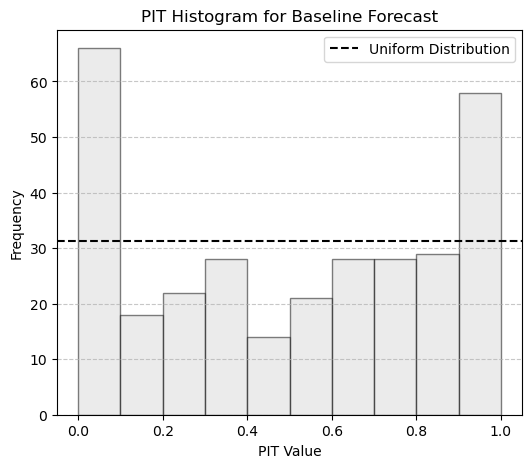

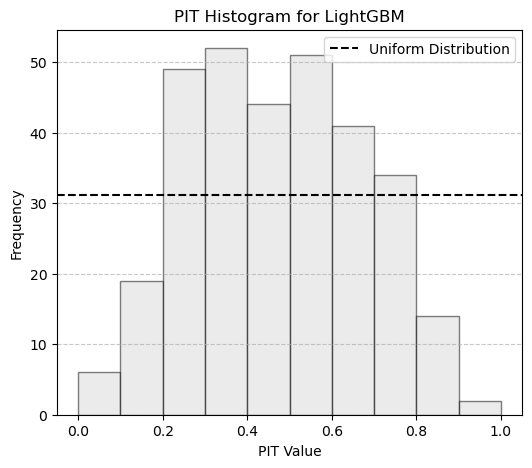

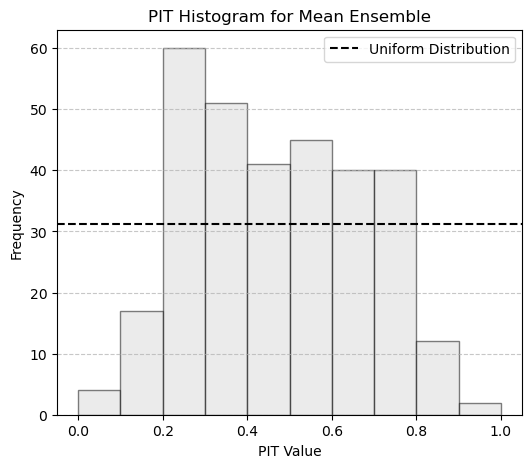

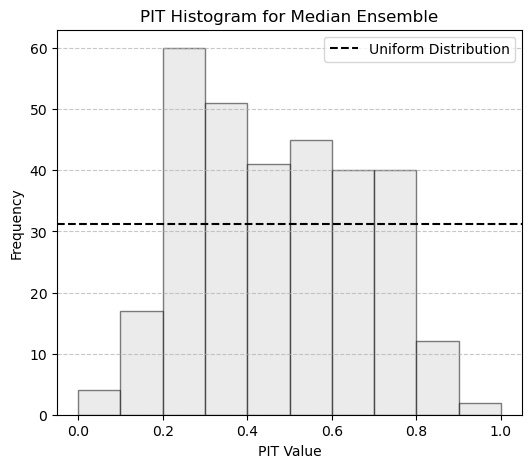

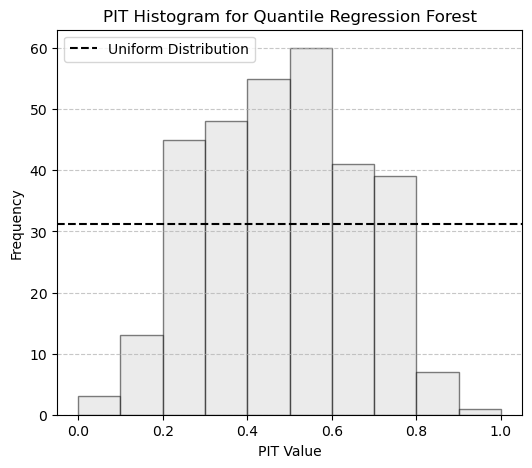

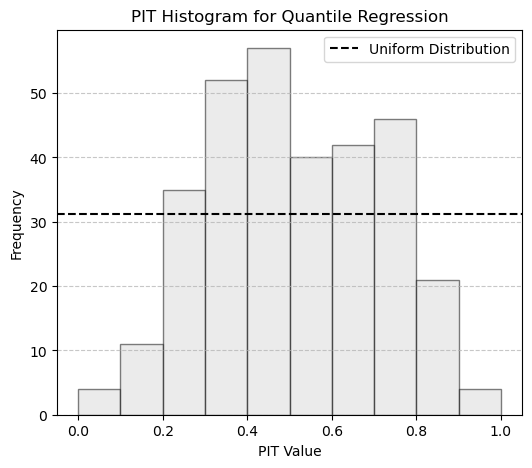

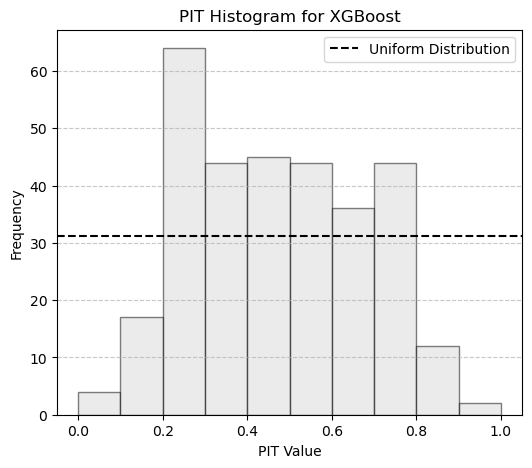

In [17]:
def calculate_pit(row):
    y_target = row['target']
    quantiles = [row['q0.025'], row['q0.25'], row['q0.5'], row['q0.75'], row['q0.975']]
    tau = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    if y_target <= quantiles[0]:
        return 0.0
    
    elif y_target >= quantiles[-1]:
        return 1.0
    
    for i in range(len(quantiles) - 1):
        if quantiles[i] <= y_target <= quantiles[i + 1]:
            return tau[i] + (y_target - quantiles[i]) / (quantiles[i + 1] - quantiles[i]) * (tau[i + 1] - tau[i])
    return np.nan 

def plot_pit_histogram_for_dict(results_dict):

    for model_name, df in results_dict.items():

        df['PIT'] = df.apply(calculate_pit, axis=1)
        
        plt.figure(figsize=(6, 5))
        plt.hist(df['PIT'].dropna(), bins=10, range=(0, 1), edgecolor='black', alpha=0.5, color='#D9D9D9')
        plt.title(f'PIT Histogram for {model_name}')
        plt.xlabel('PIT Value')
        plt.ylabel('Frequency')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.axhline(y=len(df['PIT']) / 10, color='black', linestyle='--', label='Uniform Distribution')
        plt.legend()
        plt.show()

plot_pit_histogram_for_dict(results_dict)

#### Horizon Results

In [18]:
quantile_loss_dict["Median Ensemble"]

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon
Datetime,,,,,,,
2024-02-27 01:00:00+01:00,5020.0,58.319460,131.352321,92.070792,92.589893,40.886840,1 day
2024-03-05 01:00:00+01:00,4681.0,47.793984,71.390487,32.002933,147.589052,40.335540,1 day
2024-03-12 01:00:00+01:00,4500.0,37.506997,39.757875,154.366389,158.593205,38.528948,1 day
2024-03-19 01:00:00+01:00,5595.0,67.348844,190.571522,141.055506,30.752654,25.484532,1 day
2024-03-26 01:00:00+01:00,5187.0,46.009293,28.965146,297.294585,208.687293,44.789198,1 day
...,...,...,...,...,...,...,...
2025-01-19 01:00:00+01:00,1428.0,18.005681,57.596371,24.361482,26.596485,23.590475,6 day
2025-01-26 01:00:00+01:00,1676.0,19.232322,63.027546,6.947093,30.377750,23.439741,6 day
2025-02-02 01:00:00+01:00,1526.0,13.976260,7.329983,59.144444,87.846179,36.277583,6 day


In [19]:
horizon_results = {}

for model_name, df in quantile_loss_dict.items():
    quantile_cols = [col for col in df.columns if col.startswith("q")]
    
    grouped = df.groupby("horizon")[quantile_cols].mean()
    grouped = grouped.sort_index()

    # Add total average loss (sum across quantiles per horizon)
    grouped["Total Average Loss"] = grouped.sum(axis=1)

    horizon_results[model_name] = grouped



In [20]:
horizon_results["Median Ensemble"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss
horizon,,,,,,
1 day,51.337668,196.372167,217.538472,188.764410,43.870383,697.883099
2 day,47.607532,144.156526,181.561587,150.334418,43.003427,566.663490
3 day,47.390245,153.773352,162.725205,155.514018,42.526491,561.929311
4 day,46.310746,157.504950,181.170503,157.338714,43.309229,585.634141
5 day,32.577002,124.330826,170.046950,159.579519,43.210433,529.744730
6 day,20.080659,86.482418,100.240645,83.831605,37.782879,328.418205


#### Horizon CI Coverage

In [21]:
results_dict["Median Ensemble"]

,target,q0.025,q0.25,q0.5,q0.75,q0.975,horizon,PIT
Datetime,,,,,,,,
2024-02-27 01:00:00+01:00,5020.0,2687.221587,4494.590714,4835.858417,5390.359572,6655.473601,1 day,0.583021
2024-03-05 01:00:00+01:00,4681.0,2769.240642,4395.438052,4745.005866,5271.356207,6294.421587,1 day,0.454225
2024-03-12 01:00:00+01:00,4500.0,2999.720119,4340.968501,4808.732779,5134.372819,6041.157912,1 day,0.334996
2024-03-19 01:00:00+01:00,5595.0,2901.046221,4832.713913,5312.888988,5718.010617,6614.381273,1 day,0.674090
2024-03-26 01:00:00+01:00,5187.0,3346.628290,5225.620194,5781.589171,6021.749171,6978.567911,1 day,0.245375
...,...,...,...,...,...,...,...,...
2025-01-19 01:00:00+01:00,1428.0,707.772760,1197.614514,1379.277037,1534.385941,2371.618981,6 day,0.578530
2025-01-26 01:00:00+01:00,1676.0,906.707124,1423.889817,1662.105813,1797.511000,2613.589644,6 day,0.525653
2025-02-02 01:00:00+01:00,1526.0,966.949616,1496.680069,1644.288888,1877.384715,2977.103307,6 day,0.299658


In [22]:
horizon_coverage = {}

for model_name, df in results_dict.items():
    ci_95 = (df["target"] >= df["q0.025"]) & (df["target"] <= df["q0.975"])
    ci_50 = (df["target"] >= df["q0.25"]) & (df["target"] <= df["q0.75"])

    df["CI_95_Width"] = df["q0.975"] - df["q0.025"]
    df["CI_50_Width"] = df["q0.75"] - df["q0.25"]

    df_temp = df.copy()
    df_temp["CI_95_Coverage"] = ci_95.astype(int)
    df_temp["CI_50_Coverage"] = ci_50.astype(int)

    grouped = df_temp.groupby("horizon")[
        ["CI_50_Coverage", "CI_95_Coverage", "CI_50_Width", "CI_95_Width"]
    ].mean()

    grouped = grouped.rename(columns={
        "CI_50_Coverage": "CI_50 Coverage",
        "CI_95_Coverage": "CI_95 Coverage",
        "CI_50_Width": "CI_50 Width",
        "CI_95_Width": "CI_95 Width"
    })

    horizon_coverage[model_name] = grouped.round(3)



In [23]:
horizon_summary = {}

desired_columns_order = [
    'q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975', 'Total Average Loss',
    'CI_50 Coverage', 'CI_95 Coverage', 'CI_50 Width', 'CI_95 Width'
]


for model_name in horizon_results:
    df_loss = horizon_results[model_name]
    df_cov = horizon_coverage.get(model_name)

    if df_cov is not None:
        combined = df_loss.join(df_cov)
        
        df_gerundet = combined.drop(columns=['CI_50 Coverage','CI_95 Coverage']).round(0).astype(int)
        
        df_gerundet['CI_50 Coverage'] = combined['CI_50 Coverage'].round(2)
        df_gerundet['CI_95 Coverage'] = combined['CI_95 Coverage'].round(2)
        
        df_gerundet = df_gerundet[desired_columns_order]

        horizon_summary[model_name] = df_gerundet

        


In [24]:
horizon_summary["Quantile Regression"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,73,311,349,253,53,1038,0.67,0.96,1279,4401
2 day,61,239,297,252,52,901,0.62,1.00,1508,4507
3 day,60,295,347,300,54,1056,0.62,1.00,1643,4550
4 day,56,291,337,273,54,1009,0.64,1.00,1415,4366
5 day,43,167,222,206,54,692,0.69,1.00,1121,3869
6 day,39,121,137,152,56,505,0.88,1.00,983,3796


In [25]:
horizon_summary["XGBoost"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,57,191,217,187,46,699,0.65,0.96,888,3891
2 day,50,146,187,151,47,580,0.64,1.00,909,3879
3 day,50,151,163,154,47,565,0.65,1.00,875,3889
4 day,47,152,187,152,47,585,0.67,1.00,845,3765
5 day,33,125,177,158,47,540,0.60,1.00,754,3198
6 day,20,88,109,80,44,341,0.73,1.00,512,2589


In [26]:
horizon_summary["LightGBM"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,48,202,219,191,41,701,0.67,0.98,930,3446
2 day,45,144,179,150,39,556,0.69,1.00,932,3370
3 day,45,157,164,158,38,561,0.71,1.00,937,3304
4 day,46,163,179,163,40,590,0.69,0.98,910,3344
5 day,32,124,163,163,39,522,0.64,1.00,816,2865
6 day,20,86,95,88,31,320,0.75,1.00,555,2040


In [27]:
horizon_summary["Quantile Regression Forest"]

,q0.025,q0.25,q0.5,q0.75,q0.975,Total Average Loss,CI_50 Coverage,CI_95 Coverage,CI_50 Width,CI_95 Width
horizon,,,,,,,,,,
1 day,48,210,218,199,57,732,0.79,1.0,1210,4215
2 day,48,158,177,149,51,584,0.83,1.0,1152,3977
3 day,47,173,194,181,53,647,0.75,1.0,1160,4008
4 day,47,187,217,197,53,702,0.77,1.0,1198,4003
5 day,35,135,200,197,54,621,0.69,1.0,1057,3558
6 day,24,102,119,116,45,405,0.79,1.0,725,2774
